## Project Overview

Starbucks is one of the most well-known companies in the world: a coffeehouse chain with more than 30 thousand stores all over the world. It strives to give their customers always the best service and the best experience. As a side feature, Starbucks offers their free app to make orders online, predict the waiting time and receive special offers. This app also offers promotions for bonus points to these users. The promotional offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). This project is focused on tailoring the customer behavior and responses while using the Starbucks mobile app. To avoid churn rate and trigger users to buy Starbucks products, it is important to know which offer should be sent to specific users.

## Problem Statement

The problem we are trying to solve here is, given a promotional offer and the users demographics, how likely is it that the user will be prompted by the offer. Hence this is a classification problem. We will be predicting the probability with which the customer will take up an offer or not. Hence it will help the Starbucks to minimize churn rate.

## Exploratory Data Analysis(EDA)
There are 3 available data sources provided in three JSON files as mentioned below:
1. **profile.json**: Rewards program users;
2. **portfolio.json**: Offers sent during 30-day test period;
3. **transcript.json**: Event log which records user activity during test period

This notebook is used to perform statistical analysis of the data. This will help us to understand about missing values and interaction between different variables. Lastly, a final dataset will be created which will be used in model training and performance evaluation.

### 1. Libraries

Importing useful libraries

In [2]:
!pip install imbalanced-learn

In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
sns.set_style("dark")
import warnings
warnings.filterwarnings("ignore")

In [2]:
from xgboost import XGBClassifier

### 2. Reading Files

Here we read the JSON files.

In [3]:
portfolio = pd.read_json("./raw-dataset/portfolio.json", lines=True)
profile = pd.read_json("./raw-dataset/profile.json", lines=True)
transcript = pd.read_json("./raw-dataset/transcript.json", lines=True)

#### 2.1. Profile

Exploring the profile dataframe

In [4]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [5]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


Checking if all users are unique.

In [6]:
profile.id.nunique()

17000

The below analysis shows that the **gender** and **income** columns have missing values. Also noted that, the **age** column has values encoded as **118**, which is the default for missing values.

In [7]:
profile.loc[:, "age"] = profile.loc[:, "age"].apply(lambda x: np.nan if x==118 else x)

In [8]:
profile.isnull().sum()

gender              2175
age                 2175
id                     0
became_member_on       0
income              2175
dtype: int64

Converting **became_member_on** column to a datetime field.

In [9]:
profile.loc[:, "became_member_on"] = pd.to_datetime(
                                                profile.loc[:, "became_member_on"]
                                                          .astype(str)
                                                          .apply(lambda x: f"{x[-2:]}-{x[4:-2]}-{x[:4]}")
                                        )

In [10]:
profile.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


#### 2.2. Portfolio

Exploring the portfolio dataframe

In [11]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [12]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


No missing values are noted.

Further, more noted information about three different types of offers are as mentioned below:

* __bogo__: the `difficulty` is moderate, where `reward` is spent amount

* __discount__: the `difficulty` is higher, with a lower reward

* __informational__: no `reward` and `difficulty`

In [13]:
(
    portfolio.loc[:, ["offer_type", "reward", "difficulty", "duration"]]
                .groupby("offer_type")
                .mean()
)

,reward,difficulty,duration
offer_type,,,
bogo,7.5,7.50,6.0
discount,3.0,11.75,8.5
informational,0.0,0.00,3.5


According to the dataset, offers that are listed here are time-bound. Hence, to know if a customer made transaction or not during a period, `duration` (which is calculated in days) column need to be checked .

#### 2.3. Transcript

Exploring transcript dataframe.

In [14]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [15]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


No missing values noted.

By checking the unique entries in `event` column of the transcript dataframe, analyzed fours types of events as mentioned below:

* __offer received__: which indicates an offer is sent to a customer;
* __offer viewed__: which indicates that customer actually viewed the offer;
* __transaction__: which indicates any purchase user made;
* __offer completed__: which indicates offer requirements were successfully met.

In [16]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In the available dataset, the `time` variable is expressed in hours, hence, to compare against duration of promotional offer, we can calculate this time variable in days.

In [17]:
transcript.loc[:, "time_in_days"] = transcript.loc[:, "time"] / 24

In [18]:
transcript.describe()

,time,time_in_days
count,306534.000000,306534.000000
mean,366.382940,15.265956
std,200.326314,8.346930
min,0.000000,0.000000
25%,186.000000,7.750000
50%,408.000000,17.000000
75%,528.000000,22.000000
max,714.000000,29.750000


There are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. This scenario is not considered as a customer who responed to an offer, since the customer was not influenced by the offer because the customer never viewed the offer.

### 3. Creating Final Dataset and Performing Feature Engineering

#### 3.1 Preparing labels
Our goal here is to predict customers who have higher chances of responding to a given offer. In a given point of time, for each pair of person-offer, we flag it as:
* __1__: user responded to the promotional offer
* __0__: user did not respond to the promotional offer

This will be base dataset to which more features will be appended.

##### All Offers customer received

In [19]:
offer_received = transcript.loc[transcript.event == "offer received", :]
offer_received.loc[:, "offer"] = offer_received.loc[:, "value"].apply(lambda x: x["offer id"])
offer_received = offer_received.loc[:, ["person", "offer", "time_in_days"]]

offer_received = pd.merge(offer_received, portfolio.loc[:, ["id", "duration", "difficulty"]], how="inner",
                           left_on="offer", right_on="id")

offer_received.head()

,person,offer,time_in_days,id,duration,difficulty
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5
1,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5
2,f082d80f0aac47a99173ba8ef8fc1909,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5
3,c0d210398dee4a0895b24444a5fcd1d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5
4,57dd18ec5ddc46828afb81ec5977bef2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5


##### Offers viewed on time

In [20]:
offer_viewed = transcript.loc[transcript.event == "offer viewed", :]
offer_viewed.loc[:, "offer"] = offer_viewed.loc[:, "value"].apply(lambda x: x["offer id"])

offer_viewed = pd.merge(offer_received, offer_viewed, on=["person", "offer"], 
                         how="outer", suffixes=["_received", "_viewed"])

offer_viewed = offer_viewed.loc[
    (offer_viewed.time_in_days_viewed > offer_viewed.time_in_days_received) &
    (offer_viewed.time_in_days_viewed - offer_viewed.time_in_days_received <= offer_viewed.duration), :]

cols = ["person", "offer", "duration", "difficulty", "time_in_days_received", "time_in_days_viewed"]
offer_viewed = offer_viewed.loc[:, cols]

offer_viewed.head()

,person,offer,duration,difficulty,time_in_days_received,time_in_days_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5,0.0,0.25
2,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5,24.0,29.75
3,f082d80f0aac47a99173ba8ef8fc1909,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5,0.0,2.00
6,c0d210398dee4a0895b24444a5fcd1d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5,0.0,1.25
8,a3b9b4bf115e4564933ea2e4bc936843,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5,0.0,0.75


##### Transactions for difficulty 0 (no offer completed in these scenarios)

In [21]:
transaction_completed = transcript.loc[transcript.event == "transaction", ["person", "time_in_days"]]

transaction_completed = pd.merge(offer_viewed, transaction_completed, on=["person"], suffixes=["_viewed", "_transaction_completed"],
                         how="outer")

transaction_completed = (transaction_completed.loc[
    (transaction_completed.time_in_days > transaction_completed.time_in_days_viewed) &
    (transaction_completed.time_in_days - transaction_completed.time_in_days_received <= transaction_completed.time_in_days_received) &
    (transaction_completed.difficulty == 0), ["person", "offer", "time_in_days_received", "time_in_days"]]
                              .groupby(["person", "offer", "time_in_days_received"])
                              .first()
                              .reset_index()
                              .iloc[:, :-1]
)
transaction_completed.head()

,person,offer,time_in_days_received
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0
2,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,14.0
3,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,14.0
4,0056df74b63b4298809f0b375a304cf4,3f207df678b143eea3cee63160fa8bed,21.0


##### Offers completed for all cases except promotional offers

In [22]:
offer_completed = transcript.loc[transcript.event == "offer completed", :]
offer_completed.loc[:, "offer"] = offer_completed.loc[:, "value"].apply(lambda x: x["offer_id"])

offer_completed = pd.merge(offer_viewed, offer_completed, on=["person", "offer"], 
                            how="outer", suffixes=["_viewed", "_completed"])

offer_completed = offer_completed.loc[
    (offer_completed.time_in_days > offer_completed.time_in_days_viewed) &
    (offer_completed.time_in_days - offer_completed.time_in_days_received <= offer_completed.duration) &
    (offer_completed.difficulty != 0), :]

cols = ["person", "offer", "duration", "difficulty", "time_in_days_received", 
        "time_in_days_viewed", "time_in_days"]
offer_completed = offer_completed.loc[:, cols]

offer_completed.head()

,person,offer,duration,difficulty,time_in_days_received,time_in_days_viewed,time_in_days
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,5.0,0.0,0.25,5.50
3,c0d210398dee4a0895b24444a5fcd1d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,5.0,0.0,1.25,2.75
5,32fbf97e89274e8a935903f2ad095e1f,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,5.0,0.0,4.00,6.50
8,32fbf97e89274e8a935903f2ad095e1f,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,5.0,14.0,15.00,15.25
10,4e4c47b460b1414c8ddd459b61f84b9e,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,5.0,0.0,0.50,1.00


###### Appending Results

In [23]:
offer_successful = pd.concat(
    [
        offer_completed.loc[:, ["person", "offer", "time_in_days_received"]],
        transaction_completed.loc[:, ["person", "offer", "time_in_days_received"]]
    ],
    axis=0
)
offer_successful = offer_successful.drop_duplicates()
offer_successful.loc[:, "responded_customer"] = 1
offer_successful.head()

,person,offer,time_in_days_received,responded_customer
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1
3,c0d210398dee4a0895b24444a5fcd1d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1
5,32fbf97e89274e8a935903f2ad095e1f,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1
8,32fbf97e89274e8a935903f2ad095e1f,9b98b8c7a33c4b65b9aebfe6a799e6d9,14.0,1
10,4e4c47b460b1414c8ddd459b61f84b9e,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1


##### Creating final base dataset

In [24]:
offer_received = offer_received.rename(columns={"time_in_days": "time_in_days_received"})

df = pd.merge(
    offer_received.loc[:, ["person", "offer", "time_in_days_received"]],
    offer_successful,
    on=["person", "offer", "time_in_days_received"],
    how="left"
)
df = (df.sort_values(by=["person", "offer", "time_in_days_received"])
        .fillna(0)
     )
df.loc[:, "responded_customer"] = df.loc[:, "responded_customer"].astype(int)
df.head()

,person,offer,time_in_days_received,responded_customer
22015,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0
56225,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,1
70180,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,1
42206,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,0
28317,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,0


The final base dataset consists of associated labels for each pair of person-offer at a given point in time. Hence calculating **baseline conversion rate**.

In [25]:
print(f"Baseline conversion rate(Benchmark): {100*df.responded_customer.mean():.2f}%")

Baseline conversion rate(Benchmark): 27.65%


Analysing conversion rate per each offer:

In [26]:
conversionRate_by_offer = (
    df.groupby("offer")[["responded_customer"]]
      .mean()
      .reset_index()
)

print("Baseline conversion rates segregated by offer:\n")
for idx, row in conversionRate_by_offer.iterrows():
    print(f"\t{row.offer}: {100*row.responded_customer:.2f}%")

Baseline conversion rates segregated by offer:

	0b1e1539f2cc45b7b9fa7c272da2e1d7: 14.87%
	2298d6c36e964ae4a3e7e9706d1fb8c2: 36.80%
	2906b810c7d4411798c6938adc9daaa5: 20.51%
	3f207df678b143eea3cee63160fa8bed: 27.53%
	4d5c57ea9a6940dd891ad53e9dbe8da0: 21.27%
	5a8bc65990b245e5a138643cd4eb9837: 44.36%
	9b98b8c7a33c4b65b9aebfe6a799e6d9: 19.67%
	ae264e3637204a6fb9bb56bc8210ddfd: 23.11%
	f19421c1d4aa40978ebb69ca19b0e20d: 27.12%
	fafdcd668e3743c1bb461111dcafc2a4: 41.44%


#### 3.2. Feature Engineering and Final Dataset

This section deals with enhancing features of the base dataset.

##### Customer Features

Joining profile dataframe and base dataframe

In [27]:
df = pd.merge(left=df, right=profile, right_on="id", left_on="person", how="inner")
df = df.drop(columns=["id"])
df.head()

,person,offer,time_in_days_received,responded_customer,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,M,33.0,2017-04-21,72000.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,1,M,33.0,2017-04-21,72000.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,1,M,33.0,2017-04-21,72000.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,0,M,33.0,2017-04-21,72000.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,0,M,33.0,2017-04-21,72000.0


Making decisions about features as follows:

* `gender`: categorical feature, requires conversion to category type;
* `became_member_on`: datetime feature, to estimate the period through which a given customer had been a memeber, assume a reference date as the maximum value of this field. It might not be precise, but a matter of scale.
* `age`: numerical feature, requires no changes;
* `income`: numerical feature, requires no changes.

In [28]:
df.loc[:, "period_of_membership"] = (
    (df.loc[:, "became_member_on"].max() - df.loc[:, "became_member_on"]).dt.days
)

df = df.drop(columns=["became_member_on"])
df.loc[:, "gender"] = df.loc[:, "gender"].astype("category")
df.head()

,person,offer,time_in_days_received,responded_customer,gender,age,income,period_of_membership
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,M,33.0,72000.0,595
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,1,M,33.0,72000.0,595
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,1,M,33.0,72000.0,595
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,0,M,33.0,72000.0,595
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,0,M,33.0,72000.0,595


##### Promotional Offer Features

Joining portfolio dataframe and this base dataframe.

In [29]:
df = pd.merge(right=portfolio, right_on="id", left=df, how="inner", left_on="offer")
df = df.drop(columns=["id"])
df.head()

,person,offer,time_in_days_received,responded_customer,gender,age,income,period_of_membership,reward,channels,difficulty,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,M,33.0,72000.0,595,2,"[web, email, mobile]",10,7,discount
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,17.0,0,F,19.0,65000.0,820,2,"[web, email, mobile]",10,7,discount
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,24.0,0,F,19.0,65000.0,820,2,"[web, email, mobile]",10,7,discount
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,17.0,0,M,56.0,47000.0,451,2,"[web, email, mobile]",10,7,discount
4,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,21.0,0,NaN,NaN,NaN,1007,2,"[web, email, mobile]",10,7,discount


Making decisions about the features as follows:

* `channels`: list of categories, could expand it to have one-hot encoded feature for each channel;
* `duration`: numerical feature, requires no changes;
* `difficulty`: numerical feature, requires no changes;
* `offer_type`: categorical feature, requires conversion to category type.
* `reward`: numerical feature, requires no changes;

In [30]:
channel_types = df.channels.explode().unique()

for channel in channel_types:
    df.loc[:, channel] = df.loc[:, "channels"].apply(lambda x: channel in x).astype(int)
    
df = df.drop(columns=["channels"])

df.loc[:, "offer_type"] = df.loc[:, "offer_type"].astype("category")

df.head()

,person,offer,time_in_days_received,responded_customer,gender,age,income,period_of_membership,reward,difficulty,duration,offer_type,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,M,33.0,72000.0,595,2,10,7,discount,1,1,1,0
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,17.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,24.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,17.0,0,M,56.0,47000.0,451,2,10,7,discount,1,1,1,0
4,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,21.0,0,NaN,NaN,NaN,1007,2,10,7,discount,1,1,1,0


##### Transactional Features

If a given customer makes purchases very often, it is likely that the customer will respond to an offer, or if a customer has not made any purchase for a while, the customer might activate again with an offer. Hence to study the transactional pattern of a customer more thoroughly the following features are used:

* `frequency`: how many purchases per day the customer usually makes;
* `average_purchase`: average amount spent by user.

To prevent data leakage, these features will always be calculated prior to the offer receival.

In [31]:
info_transactions = transcript.loc[transcript.event == "transaction", ["person", "value", "time_in_days"]]
info_transactions.loc[:, "amount"] = info_transactions.loc[:, "value"].apply(lambda x: x["amount"])
info_transactions = info_transactions.drop(columns=["value"])
info_transactions.head()

,person,time_in_days,amount
12654,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
12659,54890f68699049c2a04d415abc25e717,0.0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [32]:
df_key_columns = df.loc[:, ["person", "offer", "time_in_days_received"]]
df_key_columns.head()

,person,offer,time_in_days_received
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,17.0
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,24.0
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,17.0
4,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,21.0


In [33]:
transactional_features = pd.merge(df_key_columns, info_transactions, how="left", on=["person"])
transactional_features = (
    transactional_features.loc[(transactional_features.time_in_days < transactional_features.time_in_days_received), :]
)
transactional_features = (
    transactional_features.groupby(["person", "offer", "time_in_days_received"])
                       .agg({"amount": "mean", "time_in_days": "count"})
                       .reset_index()
                       .rename(columns={"amount": "average_purchase", "time_in_days": "frequency"})
)

In [34]:
df = pd.merge(df, transactional_features, how="left", on=["person", "offer", "time_in_days_received"])
df.loc[:, "average_purchase"] = df.loc[:, "average_purchase"].fillna(0)
df.loc[:, "frequency"] = df.loc[:, "frequency"].fillna(0)
df.head()

,person,offer,time_in_days_received,responded_customer,gender,age,income,period_of_membership,reward,difficulty,duration,offer_type,web,email,mobile,social,average_purchase,frequency
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,M,33.0,72000.0,595,2,10,7,discount,1,1,1,0,14.600000,4.0
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,17.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0,4.666923,13.0
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,24.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0,4.469286,14.0
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,17.0,0,M,56.0,47000.0,451,2,10,7,discount,1,1,1,0,4.855000,2.0
4,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,21.0,0,NaN,NaN,NaN,1007,2,10,7,discount,1,1,1,0,6.803333,3.0


##### Final Dataset

Useful infomation about final dataset

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76277 entries, 0 to 76276
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   person                 76277 non-null  object  
 1   offer                  76277 non-null  object  
 2   time_in_days_received  76277 non-null  float64 
 3   responded_customer     76277 non-null  int32   
 4   gender                 66501 non-null  category
 5   age                    66501 non-null  float64 
 6   income                 66501 non-null  float64 
 7   period_of_membership   76277 non-null  int64   
 8   reward                 76277 non-null  int64   
 9   difficulty             76277 non-null  int64   
 10  duration               76277 non-null  int64   
 11  offer_type             76277 non-null  category
 12  web                    76277 non-null  int32   
 13  email                  76277 non-null  int32   
 14  mobile                 76277 non-null 

##### 3.3. Train-Test Split

This section deals with splitting dataset into training set and test set.

Since the same offer could be offered to a customer more than once, data redundancy must be taken care which may cause an overestimate of the final performance. Therefore, we will consider the pair offer-person when splitting the dataset. This process will help us to avoid overfitting. In order to do that, we will combine `person` and `offer` columns and then perform hashing. The datasets are split, by bucketizing the hashing result.

In [36]:
NUM_BUCKETS = 10

df.loc[:, "hash_id"] = df.apply(lambda x: hash(x["person"]+x["offer"]) % NUM_BUCKETS, axis=1)
df.head()

,person,offer,time_in_days_received,responded_customer,gender,age,income,period_of_membership,reward,difficulty,duration,offer_type,web,email,mobile,social,average_purchase,frequency,hash_id
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,M,33.0,72000.0,595,2,10,7,discount,1,1,1,0,14.600000,4.0,8
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,17.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0,4.666923,13.0,5
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,24.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0,4.469286,14.0,5
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,17.0,0,M,56.0,47000.0,451,2,10,7,discount,1,1,1,0,4.855000,2.0,5
4,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,21.0,0,NaN,NaN,NaN,1007,2,10,7,discount,1,1,1,0,6.803333,3.0,8


In [37]:
df_train = df.loc[df.hash_id >= int(0.3 * NUM_BUCKETS), :]
df_test = df.loc[df.hash_id < int(0.3 * NUM_BUCKETS), :]
print(f"Train Size: {np.round(df_train.shape[0] / df.shape[0], 2)}")
print(f"Test Size: {np.round(df_test.shape[0] / df.shape[0], 2)}")

Train Size: 0.7
Test Size: 0.3


In [39]:
df_train.to_csv("./data/train", index=False)
df_test.to_csv("./data/validation", index=False)

### 4. Statistical Analysis

Here we do not use the test set for performing any analysis, since the test dataset is used to evaluate the performance of the model.

##### Analyzing missing values

In [40]:
df_train.isnull().sum()

person                      0
offer                       0
time_in_days_received       0
responded_customer          0
gender                   6762
age                      6762
income                   6762
period_of_membership        0
reward                      0
difficulty                  0
duration                    0
offer_type                  0
web                         0
email                       0
mobile                      0
social                      0
average_purchase            0
frequency                   0
hash_id                     0
dtype: int64

For the ease of performing analysis on numerical and categorical features, they are segregated into corresponding variables accordingly.

In [41]:
FEATURES_NUMERICAL = [
    "age", "period_of_membership", "reward", "difficulty",
    "duration", "average_purchase", "frequency"
]

FEATURES_CATEGORICAL = [
    "gender", "offer_type", "web", "email", "mobile", "social"
]

TARGET = "responded_customer"

#### 4.1. Target

Studying target variable.

##### Univariate Analysis

In [42]:
responded_customers_percentage = (df_train.responded_customer.value_counts() / len(df_train)) * 100
print("Percentage of customers reponded to promotional offer:\n")
print(responded_customers_percentage)

Percentage of customers reponded to promotional offer:

0    72.445379
1    27.554621
Name: responded_customer, dtype: float64


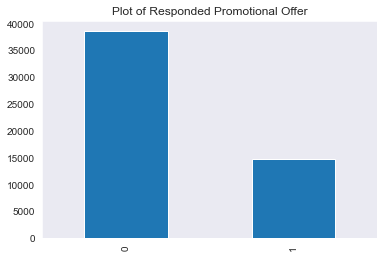

In [43]:
plt.title("Plot of Responded Promotional Offer")
df_train.responded_customer.value_counts().plot(kind="bar")
plt.show()

It is evident from the above visualization that we are dealing with an **imbalanced dataset**, since approximately 28% of the dataset responded to the promotional offer.

Addressing this problem during model development by leveraging strategies as mentioned below. Using both simultaneously can lead to better results than relying solely on a single of them.

* __oversampling__: Synthetic Minority Oversampling Technique (SMOTE) to create synthetic example of positive class;
* __weighting__: Adding different weights according to class in loss function.

#### 4.2. Numerical Features

##### Univariate Analysis

After analyzing the numerical features, we came to know that there are not many outliers except for the `average_purchase` and  `frequency` fields. As the 95th percentile and maximum values are very different from each other for these two fields.

In [45]:
df_train.loc[:, FEATURES_NUMERICAL].describe(percentiles=[np.round(p, 2) for p in np.linspace(0.05, 0.95, 5)])

,age,period_of_membership,reward,difficulty,duration,average_purchase,frequency
count,46514.000000,53276.000000,53276.000000,53276.000000,53276.000000,53276.000000,53276.000000
mean,54.333018,651.751389,4.208799,7.705458,6.504092,9.739072,3.479090
std,17.328755,422.804040,3.403284,5.546405,2.200056,17.628657,3.694951
min,18.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
5%,24.000000,142.000000,0.000000,0.000000,3.000000,0.000000,0.000000
27%,44.000000,355.000000,2.000000,5.000000,5.000000,0.000000,0.000000
50%,55.000000,534.500000,5.000000,7.000000,7.000000,3.772440,3.000000
72%,65.000000,862.000000,5.000000,10.000000,7.000000,15.440000,5.000000
95%,83.000000,1515.000000,10.000000,20.000000,10.000000,27.476250,11.000000
max,101.000000,2159.000000,10.000000,20.000000,10.000000,962.100000,29.000000


In [46]:
def plot(data: pd.DataFrame, num_cols: List[str], hue: str = None, by: str = None):
    """
    Function to plot univariate or bivariate statistical analysis.
    
    Args: 
        data (pandas dataframe): contains actual data
        num_cols (list of str): numerical columns whose plot will be displayed
        hue (str): categorical column to further discriminate data-optional
        by (str): categorical column to group data-optional
    
    Returns: 
        None
    """
    plt.figure(figsize=(12, 2*len(num_cols)))
    for i, num_col in enumerate(num_cols):
        axis = plt.subplot(len(num_cols), 1, i+1)
        if by is not None:
            sns.violinplot(y=num_col, x=by, hue=hue, data=data, ax=axis)
        else:
            sns.violinplot(x=num_col, data=data, ax=axis)
    plt.tight_layout()
    plt.show()    

After analysis noticed that the graph of `age` is closer to a normal distribution.The features related to the offers available are limited to certain values, which results in very few representative values.

A skewed distribution is noticed for `period_of_membership` and `frequency` features, whereas `average_purchase` concetrates almost all values close to zero - in this case, outliers might be a problem. Perhaps some sort of winsorizing is useful.

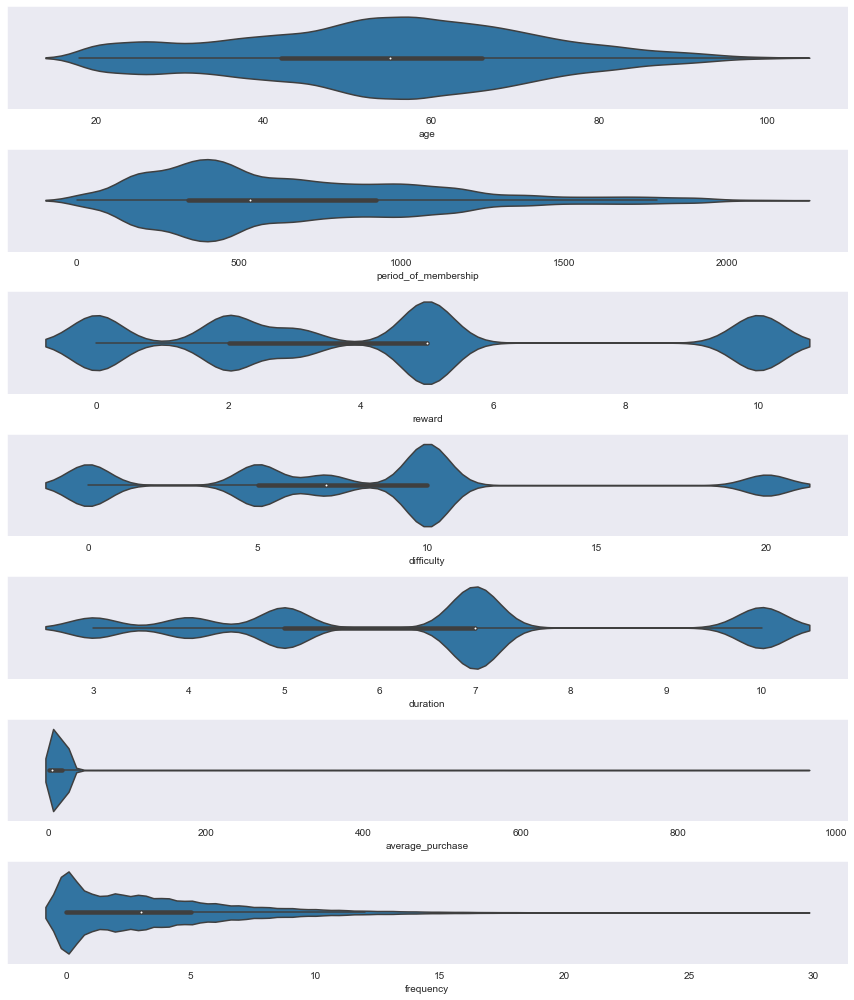

In [47]:
plot(df_train, FEATURES_NUMERICAL)

Plotting histograms for statistical analysi. Using the actual data and numerical features for which histogram will be plotted

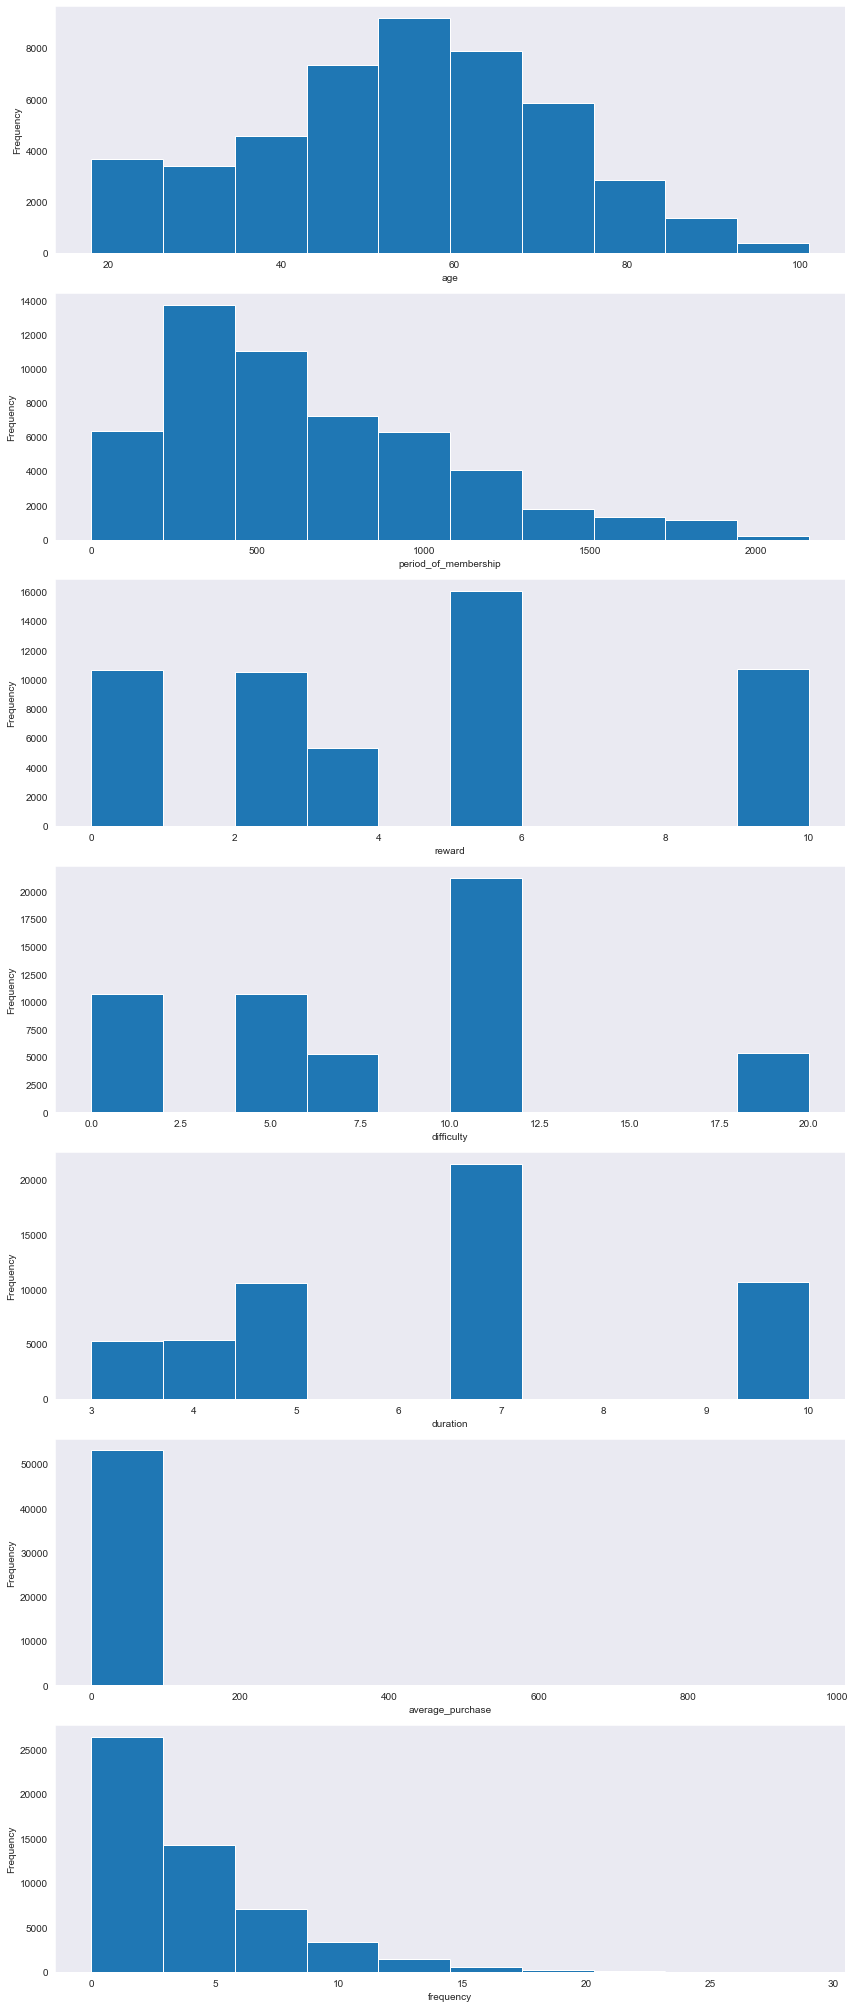

In [48]:
plt.figure(figsize=(12, 4*len(FEATURES_NUMERICAL)))
for i, num_col in enumerate(FEATURES_NUMERICAL):
    axis = plt.subplot(len(FEATURES_NUMERICAL), 1, i+1)
    df_train.loc[:, num_col].plot(ax=axis,kind='hist')
    axis.set_xlabel(num_col)
plt.tight_layout()
plt.show()

##### Bivariate Analysis

* Numerical Features

It is evident from the below correlation heatmap that only `difficulty` and `duration` are the only highly-correlated pair. We could decide to follow with only one of them after checking its behaviour with target.

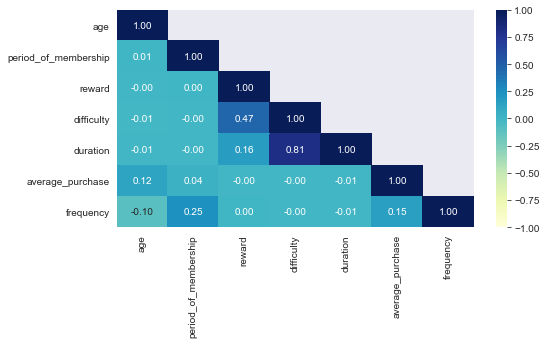

In [49]:
corr = df_train.loc[:, FEATURES_NUMERICAL].corr()
mask = np.zeros_like(corr).astype(bool)
mask[np.triu_indices_from(corr, k=1)] = True
plt.figure(figsize=(8, 4))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt=".2f", mask=mask, cmap="YlGnBu")
plt.show()

* Target Feature

From the below visualization it is clear how `difficulty` discriminates more against the target variable.

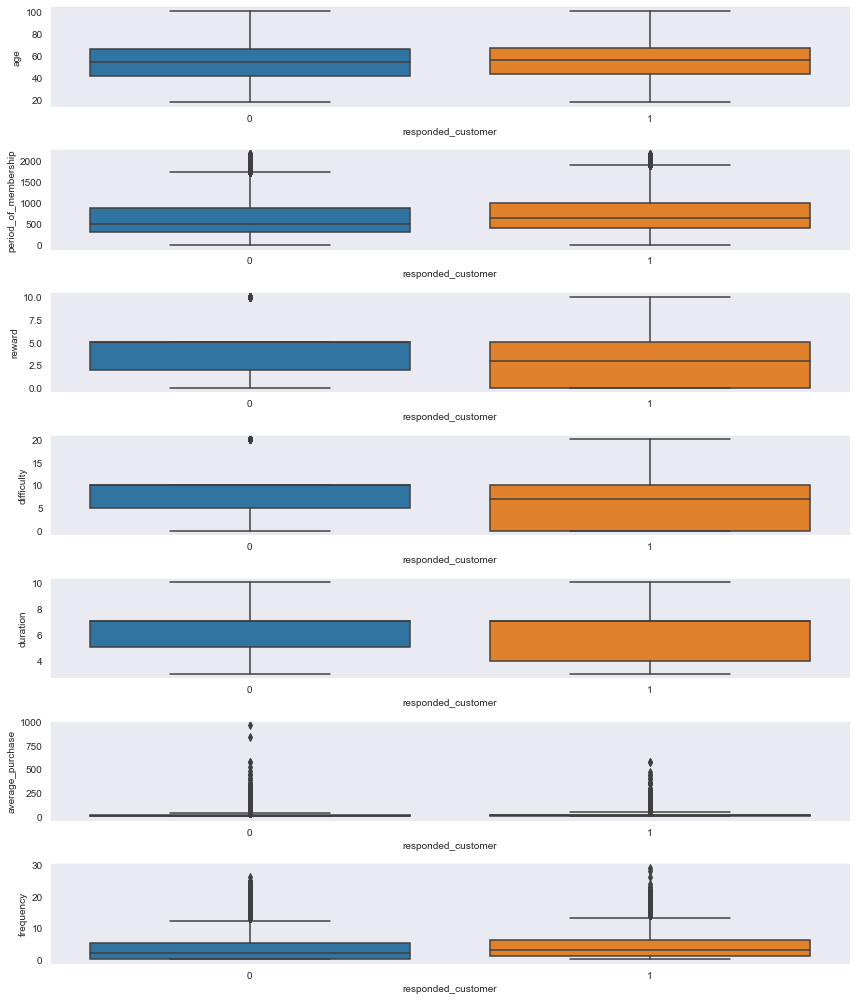

In [50]:
by = TARGET
plt.figure(figsize=(12, 2*len(FEATURES_NUMERICAL)))
for i, column in enumerate(FEATURES_NUMERICAL):
    axis = plt.subplot(len(FEATURES_NUMERICAL), 1, i+1)
    if by is not None:
        sns.boxplot(y=column, x=by, data=df_train, ax=axis)
    else:
        sns.boxplot(x=column, data=df_train, ax=axis)
plt.tight_layout()
plt.show()

+ Categorical Variables

The below visualization shows that regarding `gender`, there is no much difference in how variables are distributed.

But we can noticed that long-term users tend to respond to promotional offers regardless of the reward, as long as they do not require a high amount to be spent.

[GENDER]


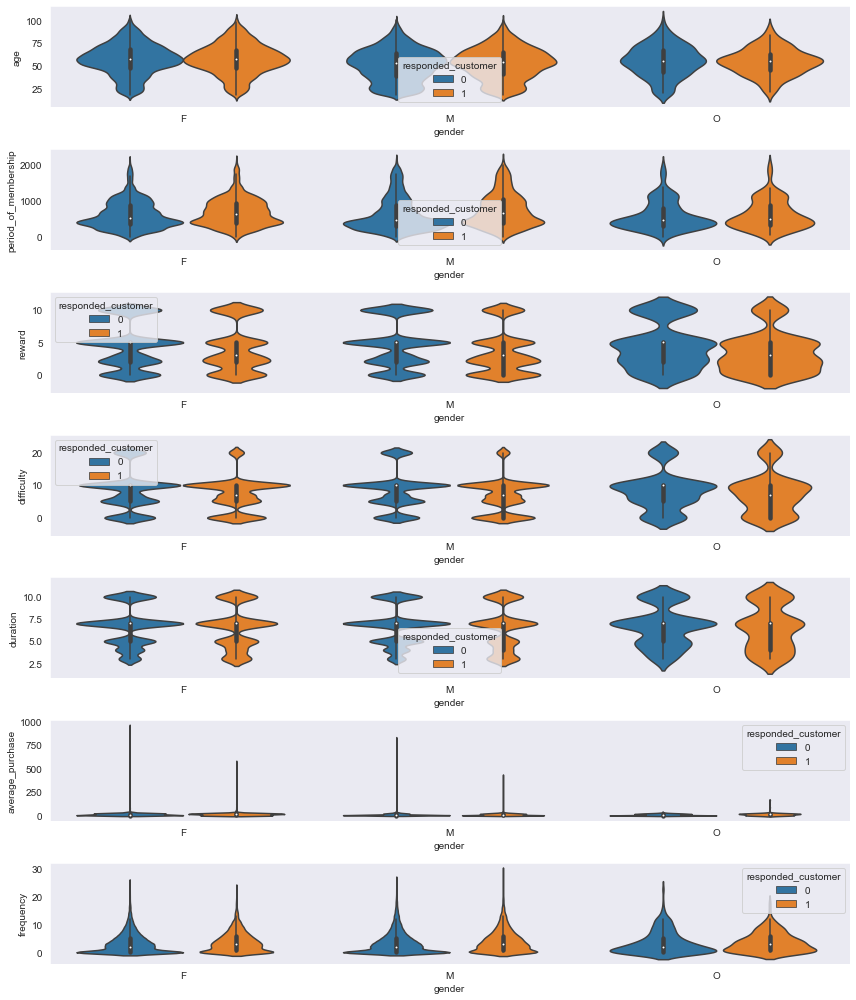

[OFFER_TYPE]


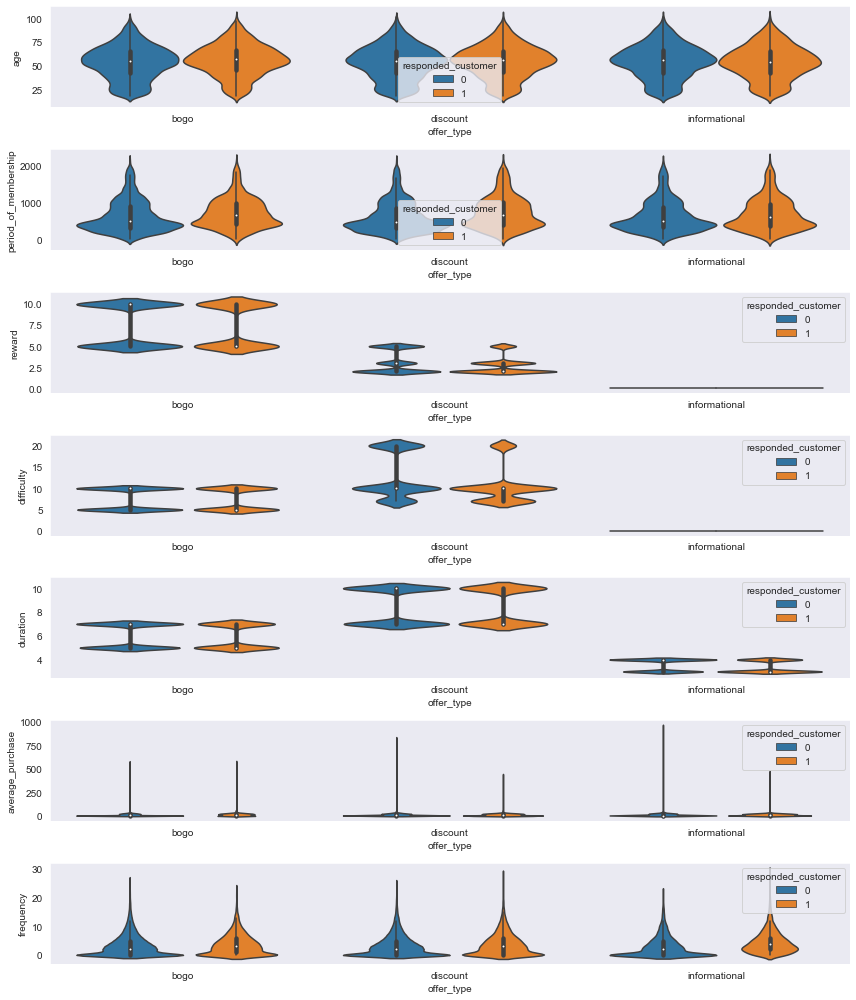

[WEB]


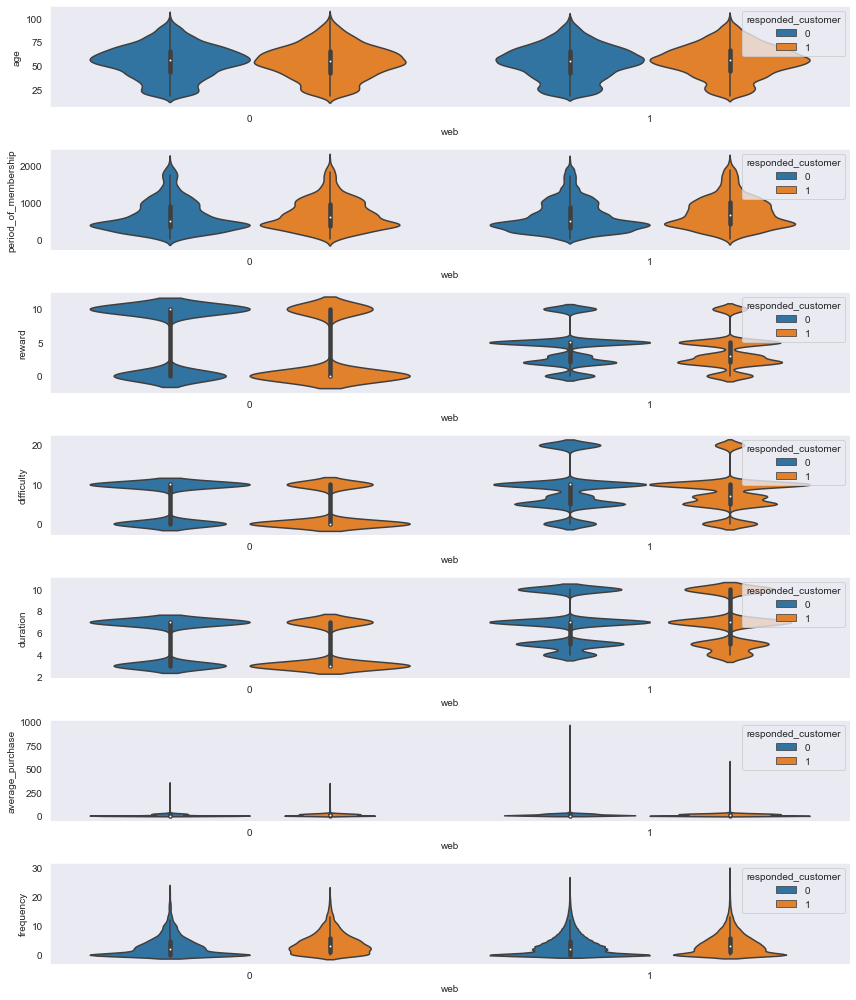

[EMAIL]


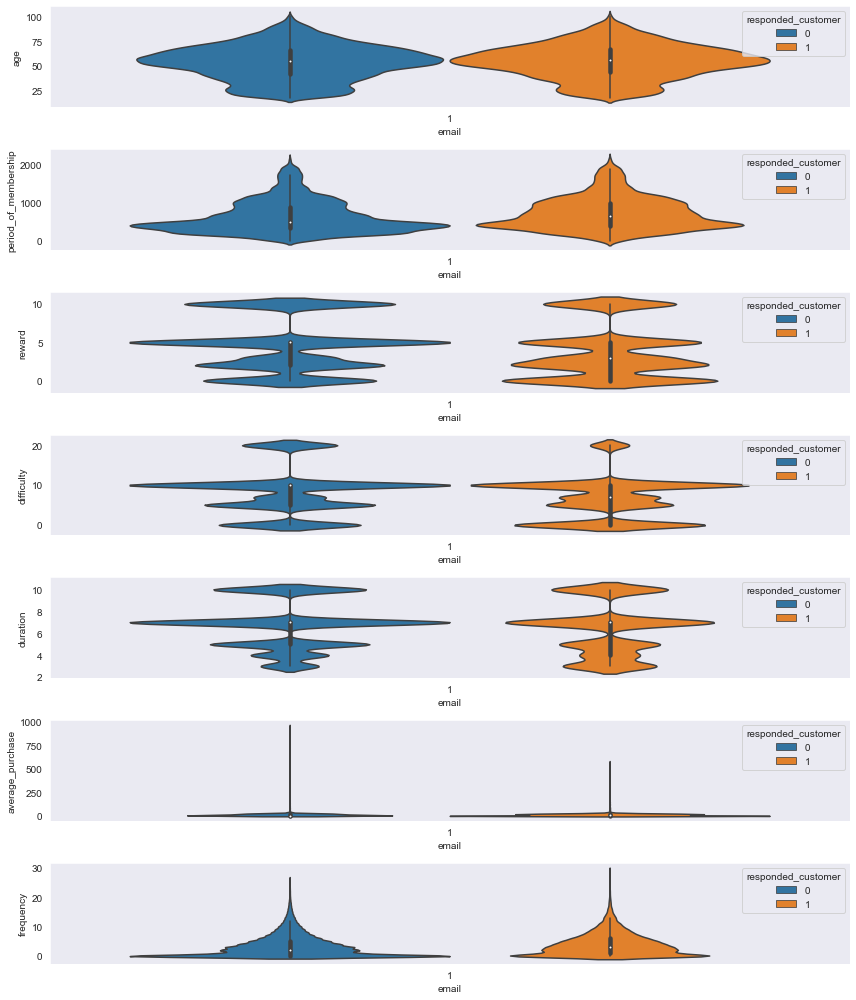

[MOBILE]


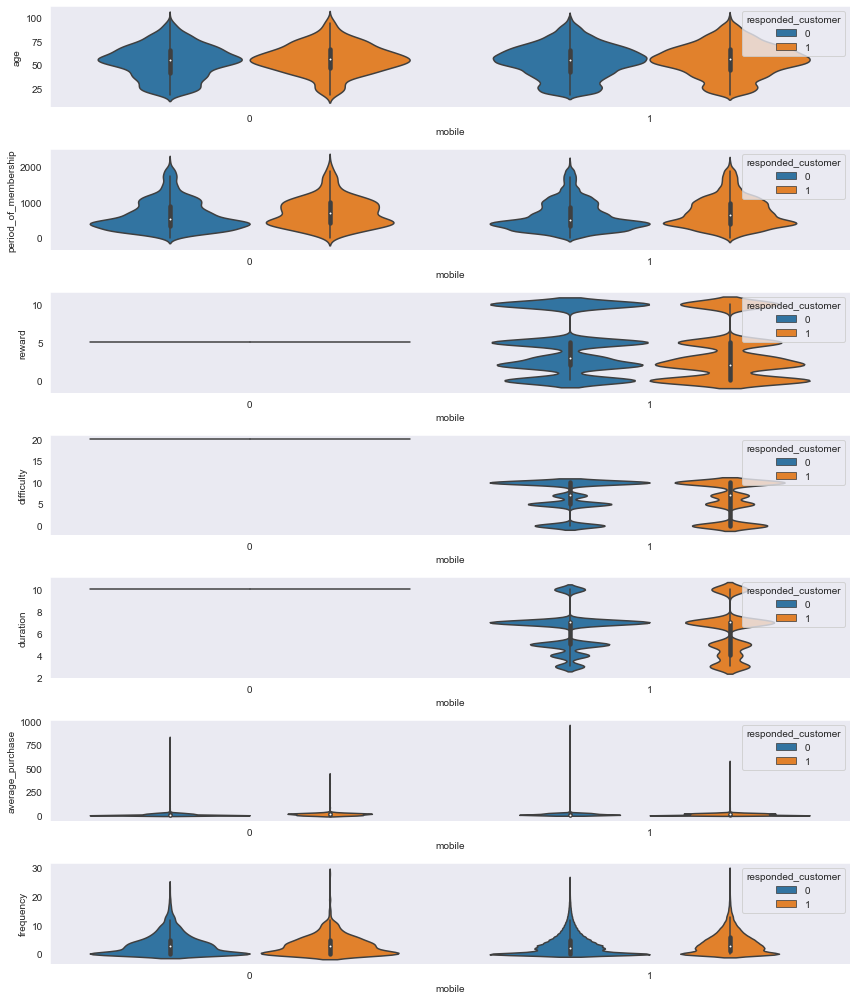

[SOCIAL]


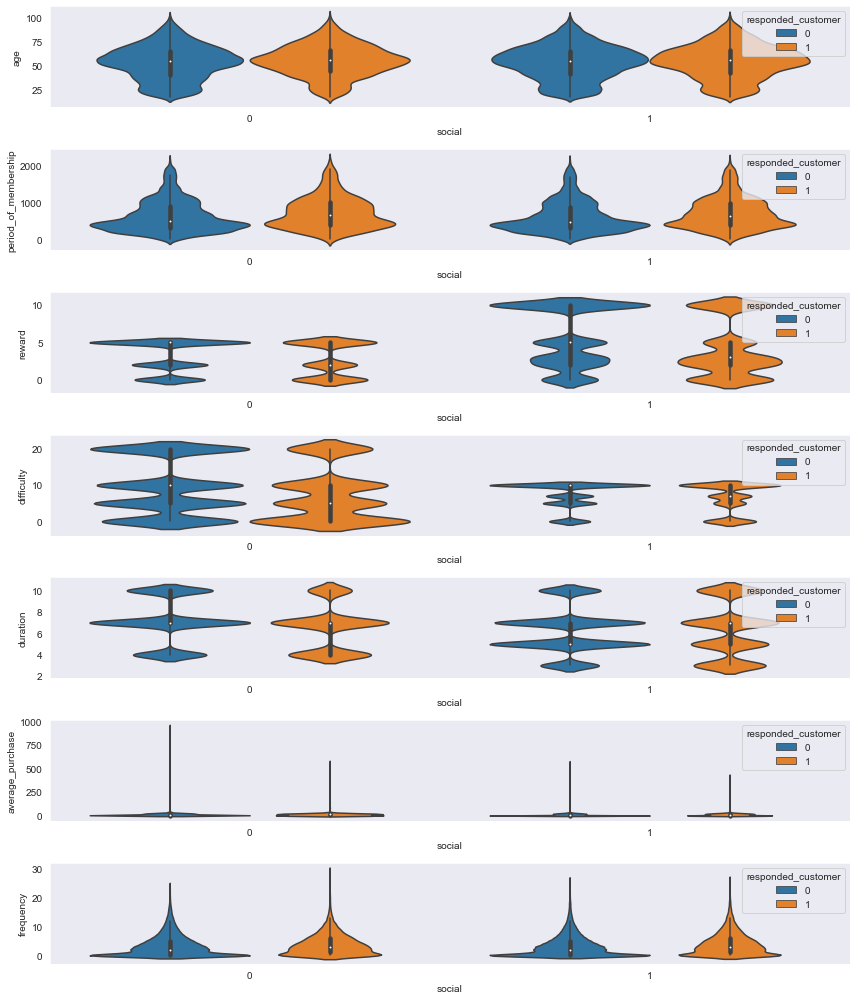

In [51]:
for category in FEATURES_CATEGORICAL:
    print(f"[{category.upper()}]")
    plot(df_train, FEATURES_NUMERICAL, hue=TARGET, by=category)

#### 4.3. Categorical Features

##### Univariate Analysis

Conclusions drawn from the below visualization are as stated below:

*  The majority of customers who took part in the 30-day test period are male
*  The most common types of offers are BOGO and discount. 
*  Informational offers were less often used in this context.

In [52]:
def count_plot(data: pd.DataFrame, categorical_columns: List[str], hue: str = None):
    """
    Function to plot for univariate or bivariate statistical analysis.
    
    Args: 
        data (pandas dataframe): contains actual data
        cat_cols (list of str): categorical columns whose plots will be displayed
        hue (str): categorical column to discriminate the data further-optional
    
    Returns: 
        None
    """
    val_multiplier = 2
    if hue is not None:
        val_multiplier = max([val_multiplier, df.loc[:, hue].nunique()])
    plt.figure(figsize=(12, val_multiplier*len(categorical_columns)))
    for i, column in enumerate(categorical_columns):
        axis = plt.subplot(len(categorical_columns), 1, i+1)
        if hue is not None:
            sns.countplot(y=column, hue=hue, data=data, ax=axis)
        else:
            sns.countplot(x=column, data=data, ax=axis)
    plt.tight_layout()
    plt.show()

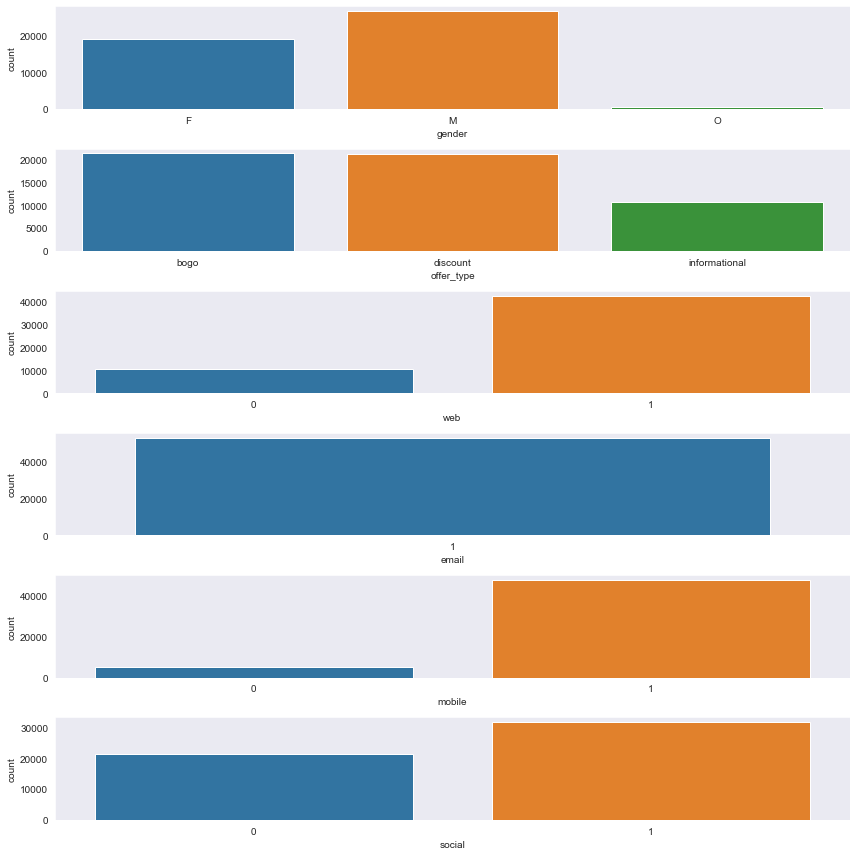

In [53]:
count_plot(df_train, FEATURES_CATEGORICAL)

##### Bivariate Analysis

In comparison to other offer types, there is greater share of respondents in **offer_type** - informational.

Regarding **gender**, since there are fewer examples to conclude anything at all with statistical confidence, hence could infer that female customers tend to respond to promotional offers than male customers.

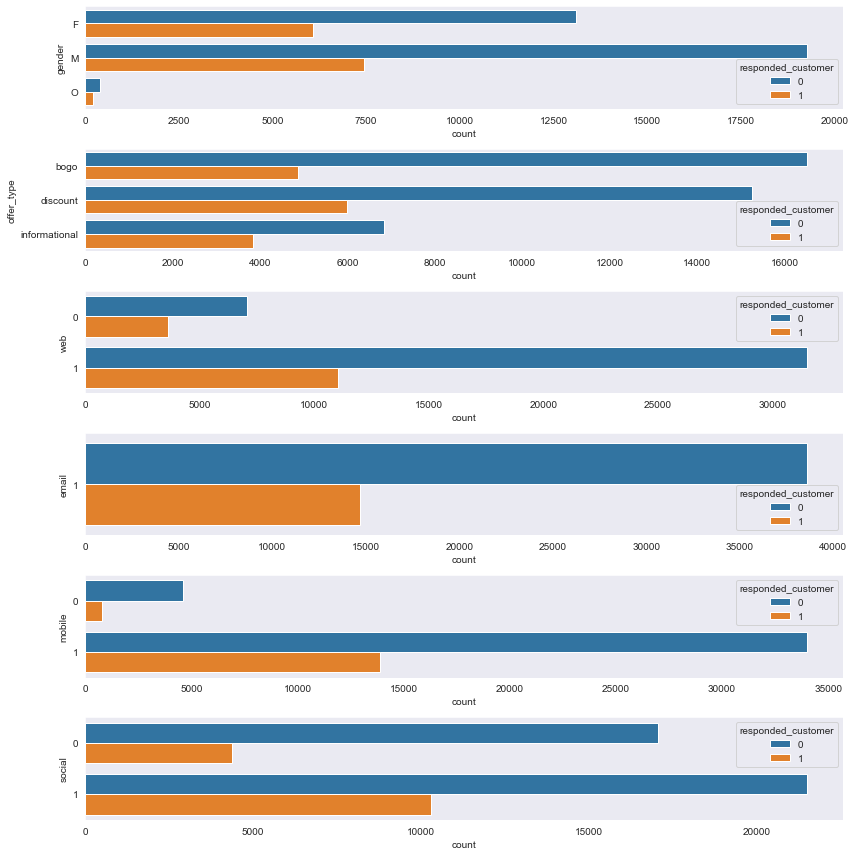

In [54]:
count_plot(df_train, FEATURES_CATEGORICAL, hue=TARGET)

### 5. Preprocessing and XGBoost with Default Parameters

In order to allow further model training and hyperparameter tuning in SageMaker, here we will only build the pipeline and fit it in order to assess feasibility.

Further development will take place in the scripts uploaded to SageMaker.

Selecting the numerical, categorical, encoded categorical and target features going to be used in the model. Also, notice that since `difficulty` has a better relationship to the target variable, we removed `duration`.

In [55]:
FEATURES_NUMERICAL = [
    "age", "period_of_membership", "reward", "difficulty",
    "duration", "average_purchase", "frequency"
]

FEATURES_CATEGORICAL = [
    "gender", "offer_type"
]

FEATURES_CATEGORICAL_ENCODED = [
    "web", "email", "mobile", "social"
]

TARGET = "responded_customer"

In [56]:
X_train, y_train = df_train.loc[:, FEATURES_NUMERICAL+FEATURES_CATEGORICAL+FEATURES_CATEGORICAL_ENCODED], \
                   df_train.loc[:, TARGET].values

X_test, y_test = df_test.loc[:, FEATURES_NUMERICAL+FEATURES_CATEGORICAL+FEATURES_CATEGORICAL_ENCODED], \
                 df_test.loc[:, TARGET].values

#### 5.1. Preprocessing Pipeline

In [63]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from imblearn.over_sampling import SMOTE

In [65]:
from preprocessing_script import *

In [66]:
preprocessing_numerical = Pipeline(steps=[
    ("num_cols", df_ColSelector(cols=FEATURES_NUMERICAL)),
    ("num_imputer", NumericImputer(method="median")),
    ("std_scaler", StandardScaler())
])

preprocessing_categorical = Pipeline(steps=[
    ("cat_cols", df_ColSelector(cols=FEATURES_CATEGORICAL)),
    ("cat_imputer", CategoricalImputer(method="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

preprocessing_categorical_encoded = Pipeline(steps=[
    ("cat_encoded_cols", df_ColSelector(cols=FEATURES_CATEGORICAL_ENCODED)),
    ("cat_encoded_imputer", CategoricalImputer(method="most_frequent")),
])

steps_preprocessor = FeatureUnion(transformer_list=[
    ("preprocessing_numerical", preprocessing_numerical),
    ("preprocessing_categorical", preprocessing_categorical),
    ("preprocessing_categorical_encoded", preprocessing_categorical_encoded),
])

In [67]:
X_train_processed = steps_preprocessor.fit_transform(X_train, y_train)
X_test_processed = steps_preprocessor.transform(X_test)

In [68]:
SAMPLING_STRATEGY = 0.5

smote = SMOTE(sampling_strategy=SAMPLING_STRATEGY)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

#### 5.2. Model Development

In [69]:
xgb_clf = XGBClassifier(
        objective='binary:logistic',
        eval_metric='error', 
        max_depth=5,
        n_estimators=100,
        gamma=0,
        scale_pos_weight=1/SAMPLING_STRATEGY,
        learning_rate=0.1,
        random_state=90
)

In [70]:
xgb_clf.fit(X_train_balanced, y_train_balanced)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=90,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.0, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### 5.3. Model Inference

In [77]:
pipeline_model_prediction = Pipeline(steps=[
    ("preprocessing", steps_preprocessor),
    ("xgboost", xgb_clf)
])

In [78]:
pipeline_model_prediction.predict(X_test)

array([1, 1, 0, ..., 0, 0, 0])

In [79]:
pipeline_model_prediction.predict_proba(X_test)

array([[0.46338463, 0.5366154 ],
       [0.46338463, 0.5366154 ],
       [0.86902   , 0.13098003],
       ...,
       [0.8369194 , 0.16308054],
       [0.74519515, 0.25480488],
       [0.5862026 , 0.41379735]], dtype=float32)